# Model Evaluation

This notebook demonstrates the model evaluation pipeline: loading raw signals, applying STFT transformation, running inference through the ResNet autoencoder, and reconstructing the signal via inverse STFT.


## 1. Import packages


In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy.ndimage import zoom

# Add src to path
sys.path.insert(0, str(Path.cwd() / "src"))

from resnet_autoencoder import ResNetAutoencoder
from dataset import STFTDataset, STFTConfig
from signal_utils import inverse_stft, zscore
from config_utils import load_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## 2. Load configuration and model


In [2]:
# Load configuration
config_path = Path("configs/config.json")
cfg = load_config(config_path)

# Load pretrained model
model_path = Path("models/model_2024_08_23__162411.pth")
model = ResNetAutoencoder(
    encoded_space_dim=cfg["model"]["resnet_autoencoder"]["encoded_space_dim"],
    output_channels=cfg["model"]["resnet_autoencoder"]["output_channels"],
    dropout=cfg["model"]["resnet_autoencoder"]["dropout"],
).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"Loaded model from: {model_path}")


/root/miniconda3/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded model from: models/model_2024_08_23__162411.pth


## 3. Load raw signal data


In [3]:
# Load sample radar and ECG signals
radar_path = Path("eval_data/sample_radar.npy")
ecg_path = Path("eval_data/sample_ecg.npy")

radar_signal = np.load(radar_path)
ecg_signal = np.load(ecg_path)

print(f"Radar signal length: {len(radar_signal)} samples")
print(f"ECG signal length: {len(ecg_signal)} samples")
print(f"Sampling rate: {cfg['data']['fs_target']} Hz")
print(f"Duration: {len(radar_signal) / cfg['data']['fs_target']:.2f} seconds")


Radar signal length: 640 samples
ECG signal length: 640 samples
Sampling rate: 128 Hz
Duration: 5.00 seconds


## 4. STFT transformation and model inference


In [4]:
# Normalize radar signal
radar_norm = radar_signal - radar_signal.mean()
radar_norm = radar_norm / (radar_norm.std() + 1e-6)

# Apply STFT transformation
stft_cfg = STFTConfig(
    fs=cfg["data"]["fs_target"],
    window_length=cfg["stft"]["window_length"],
    noverlap=cfg["stft"]["noverlap"],
    nfft=cfg["stft"]["nfft"],
    radar_bandpass=tuple(cfg["filters"]["radar_bandpass"]),
    ecg_bandpass=tuple(cfg["filters"]["ecg_bandpass"]),
    filter_order=cfg["filters"]["order"],
)

stft_map = STFTDataset.stft(radar_norm, stft_cfg)
orig_shape = stft_map.shape  # (time, freq*2)

# STFTDataset.stft already zooms to (64, 64), so we can use it directly
stft_tensor = torch.tensor(stft_map, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

print(f"STFT shape (already zoomed to 64x64): {stft_map.shape}")
print(f"Input tensor shape: {stft_tensor.shape}")

# Model inference
with torch.no_grad():
    recon_map = model(stft_tensor).squeeze(0).squeeze(0).cpu().numpy()

print(f"Reconstructed STFT shape: {recon_map.shape}")


STFT shape (already zoomed to 64x64): (64, 64)
Input tensor shape: torch.Size([1, 1, 64, 64])
Reconstructed STFT shape: (64, 64)


In [5]:
# Reconstruct signal from STFT
recon_signal = inverse_stft(
    recon_map,
    cfg,
    cutoff=4.0,
    use_input_phase=False,
    phase_override=None,
    expected_samples=len(radar_signal),
)

print(f"Reconstructed signal length: {len(recon_signal)} samples")
print(f"Original signal length: {len(radar_signal)} samples")


Reconstructed signal length: 640 samples
Original signal length: 640 samples


## 6. Visualization


Figure saved to: outputs/model_eval_comparison.png


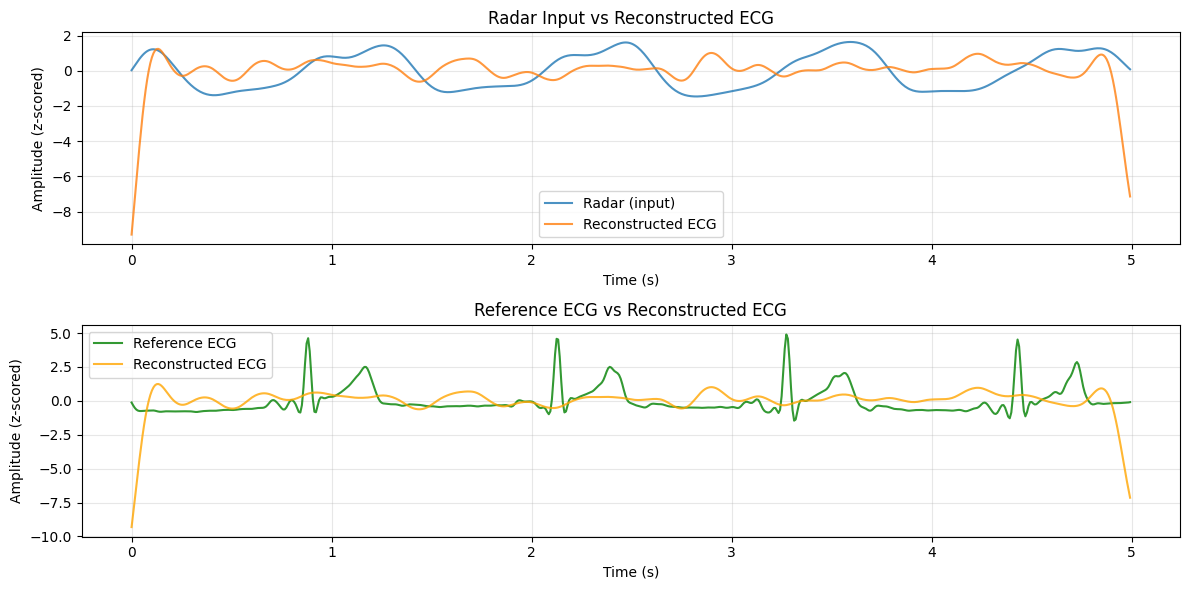

In [6]:
# Create time axis
fs = cfg["data"]["fs_target"]
time_axis = np.arange(len(radar_signal)) / fs

# Ensure same length for plotting
min_len = min(len(radar_signal), len(recon_signal), len(ecg_signal))
time_plot = time_axis[:min_len]
radar_plot = radar_signal[:min_len]
recon_plot = recon_signal[:min_len]
ecg_plot = ecg_signal[:min_len]

# Plot comparison
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_plot, zscore(radar_plot), label="Radar (input)", alpha=0.8, linewidth=1.5)
plt.plot(time_plot, zscore(recon_plot), label="Reconstructed ECG", alpha=0.8, linewidth=1.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (z-scored)")
plt.title("Radar Input vs Reconstructed ECG")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(time_plot, zscore(ecg_plot), label="Reference ECG", alpha=0.8, linewidth=1.5, color='green')
plt.plot(time_plot, zscore(recon_plot), label="Reconstructed ECG", alpha=0.8, linewidth=1.5, color='orange')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (z-scored)")
plt.title("Reference ECG vs Reconstructed ECG")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("outputs/model_eval_comparison.png", dpi=200, bbox_inches='tight')
print("Figure saved to: outputs/model_eval_comparison.png")
plt.show()


Pearson Correlation Coefficient (PCC): 0.0371
Overlay figure saved to: outputs/model_eval_overlay.png


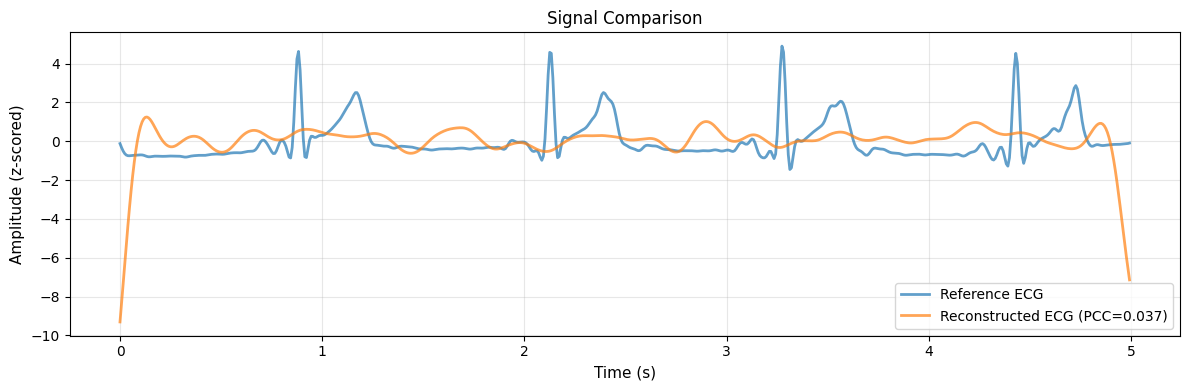

In [7]:
# Calculate correlation
from scipy.stats import pearsonr

pcc = pearsonr(zscore(ecg_plot), zscore(recon_plot))[0]
print(f"Pearson Correlation Coefficient (PCC): {pcc:.4f}")

# Plot overlay comparison
plt.figure(figsize=(12, 4))
plt.plot(time_plot, zscore(ecg_plot), label="Reference ECG", alpha=0.7, linewidth=2)
plt.plot(time_plot, zscore(recon_plot), label=f"Reconstructed ECG (PCC={pcc:.3f})", alpha=0.7, linewidth=2)
plt.xlabel("Time (s)", fontsize=11)
plt.ylabel("Amplitude (z-scored)", fontsize=11)
plt.title("Signal Comparison", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("outputs/model_eval_overlay.png", dpi=200, bbox_inches='tight')
print("Overlay figure saved to: outputs/model_eval_overlay.png")
plt.show()
